# B+ Mass Distribution - Ntuple Level

This notebook loads all real data (2016-2018, both magnet polarities, both LL and DD) and plots the B+ mass distribution without any cuts.

In [4]:
# Import necessary libraries
import sys
from pathlib import Path

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
from modules.data_handler import DataManager, TOMLConfig

print("✓ Imports successful")

✓ Imports successful


In [ ]:
config = TOMLConfig(config_dir="../config")
data_manager = DataManager(config)

print("✓ Configuration loaded")

✓ Configuration loaded


In [ ]:
# Load all real data
years = ["2016", "2017", "2018"]
magnets = ["MD", "MU"]
track_types = ["LL", "DD"]

all_data = []

for year in years:
    for magnet in magnets:
        for track_type in track_types:
            print(f"Loading {year} {magnet} {track_type}...")
            data = data_manager.load_tree(
                particle_type="data",
                year=year,
                magnet=magnet,
                track_type=track_type,
                apply_derived_branches=False,
                apply_trigger=False
            )
            if data is not None:
                all_data.append(data)
                print(f"  → Loaded {len(data)} events")

combined_data = ak.concatenate(all_data)
print(f"\n✓ Total events loaded: {len(combined_data)}")

Loading 2016 MD LL...


  → Loaded 125372 events
Loading 2016 MD DD...
  → Loaded 87347 events
Loading 2016 MU LL...
  → Loaded 108858 events
Loading 2016 MU DD...
  → Loaded 74347 events
Loading 2017 MD LL...
  → Loaded 106933 events
Loading 2017 MD DD...
  → Loaded 87617 events
Loading 2017 MU LL...
  → Loaded 101598 events
Loading 2017 MU DD...
  → Loaded 82367 events
Loading 2018 MD LL...
  → Loaded 131547 events
Loading 2018 MD DD...
  → Loaded 112514 events
Loading 2018 MU LL...
  → Loaded 139324 events
Loading 2018 MU DD...
  → Loaded 117736 events

✓ Total events loaded: 1275560


In [59]:
# Extract B+ mass (Bu_MM is the measured mass at ntuple level)
bu_mass = np.asarray(combined_data["Bu_MM"])

print("B+ mass statistics:")
print(f"  Mean: {np.mean(bu_mass):.2f} MeV/c²")
print(f"  Std:  {np.std(bu_mass):.2f} MeV/c²")
print(f"  Min:  {np.min(bu_mass):.2f} MeV/c²")
print(f"  Max:  {np.max(bu_mass):.2f} MeV/c²")
print (len(bu_mass))

B+ mass statistics:
  Mean: 5620.65 MeV/c²
  Std:  703.37 MeV/c²
  Min:  4499.77 MeV/c²
  Max:  7011.21 MeV/c²
1275560


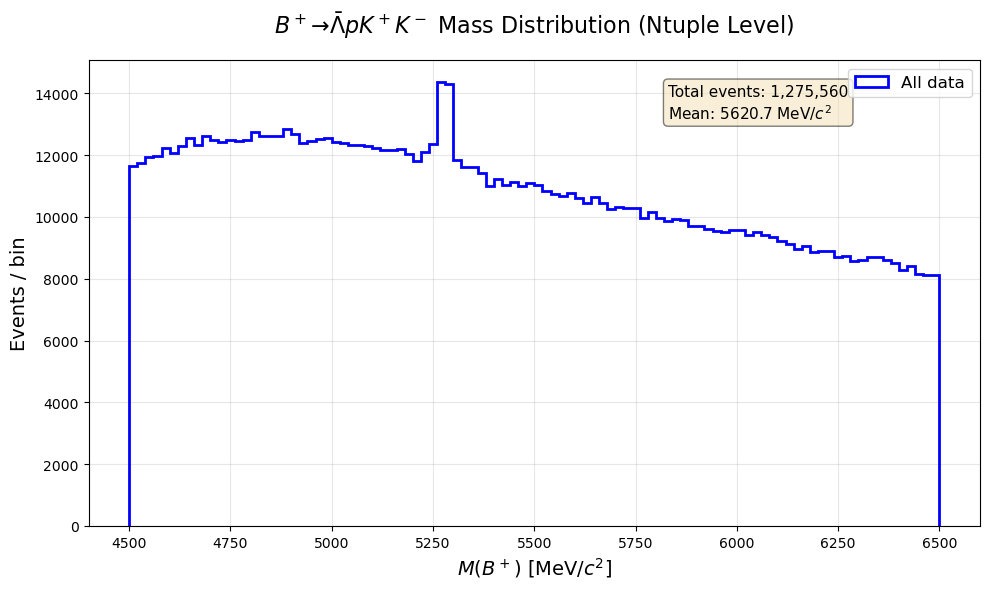

✓ Plot complete


In [50]:
# Plot B+ mass distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram
n, bins, patches = ax.hist(bu_mass, bins=100, range=(4500, 6500),
                           histtype='step', linewidth=2, color='blue', label='All data')

# Formatting
ax.set_xlabel(r'$M(B^+)$ [MeV/$c^2$]', fontsize=14)
ax.set_ylabel('Events / bin', fontsize=14)
ax.set_title(r'$B^+ \to \bar{\Lambda} p K^+ K^-$ Mass Distribution (Ntuple Level)',
             fontsize=16, pad=20)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Add text with statistics
textstr = f'Total events: {len(bu_mass):,}\nMean: {np.mean(bu_mass):.1f} MeV/$c^2$'
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Plot complete")

## Fit the B+ Mass Distribution

Now let's fit the mass distribution using:
- **Signal**: Single Gaussian centered around the B+ mass (5279 MeV/c²)
- **Background**: Linear function

We'll use the fitle_old package for fitting.

In [18]:
# Import fitle_old package
import sys

sys.path.insert(0, str(Path.cwd()))

import fitle_old as fl

print("✓ fitle_old imported successfully")
print(f"Available functions: {fl.__all__}")

✓ fitle_old imported successfully
Available functions: ['Param', 'P', 'Q', 'U', 'X', 'index', 'I', 'Model', 'Reduction', 'const', 'indecise', 'fit', 'FitResult', 'Cost', 'gaussian', 'exponential', 'uniform', 'crystal_ball', 'Compiler']


In [19]:
# Define fit range (around the B+ peak)
fit_min, fit_max = 5000, 5600  # MeV/c²

# Select data in fit range
fit_mask = (bu_mass > fit_min) & (bu_mass < fit_max)
data_to_fit = bu_mass[fit_mask]

print(f"Fitting range: [{fit_min}, {fit_max}] MeV/c²")
print(f"Events in fit range: {len(data_to_fit):,}")

Fitting range: [5000, 5600] MeV/c²
Events in fit range: 354,503


In [27]:
# Create a histogram to understand the data better
hist_counts, hist_edges = np.histogram(data_to_fit, bins=nbins, range=(fit_min, fit_max))
hist_centers = (hist_edges[:-1] + hist_edges[1:]) / 2

# Find approximate peak position and height
peak_idx = np.argmax(hist_counts)
peak_mass = hist_centers[peak_idx]
peak_height = hist_counts[peak_idx]

# Estimate background level (average of first and last few bins)
bkg_level = (np.mean(hist_counts[:10]) + np.mean(hist_counts[-10:])) / 2

print(f"Peak position: ~{peak_mass:.1f} MeV/c²")
print(f"Peak height: ~{peak_height:.0f} events/bin")
print(f"Background level: ~{bkg_level:.0f} events/bin")
print(f"Estimated signal events: ~{(peak_height - bkg_level) * 10:.0f}")  # rough estimate

Peak position: ~5279.0 MeV/c²
Peak height: ~4655 events/bin
Background level: ~3466 events/bin
Estimated signal events: ~11886


In [28]:
# Define the fit model: Gaussian signal + linear background

# Signal: Gaussian
# Parameters: mu (mean), sigma (width)
mu = fl.P('mu')[5250, 5310](5279)  # name, [min, max], (initial value)
sigma = fl.Q('sigma')[1, 100](20)  # positive constraint, (initial value)

signal = fl.gaussian(mu, sigma)

# Background: Linear (a0 + a1 * X) - but we'll fit it as a constant for simplicity
# In the fit range, linear is approximately constant
a0 = fl.Q('a0')(3000)  # constant background level per bin
a1 = fl.P('a1')[-1, 1](-0.1)  # small linear slope

background = a0 + a1 * fl.X

# Total model: Signal yield * signal + background
# The Gaussian is already normalized, so n_signal * signal gives the signal contribution
# We need to scale by bin width
bin_width = (fit_max - fit_min) / nbins
n_signal = fl.Q('n_signal')(10000)  # number of signal events (positive)

model = n_signal * signal * bin_width + background

print("✓ Model defined:")
print("  Signal: n_signal * Gaussian(mu, sigma) * bin_width")
print("  Background: a0 + a1 * X")
print(f"\nFit parameters: {[p.name for p in model.params]}")

✓ Model defined:
  Signal: n_signal * Gaussian(mu, sigma) * bin_width
  Background: a0 + a1 * X

Fit parameters: ['n_signal', 'sigma', 'mu', 'a0', 'a1']


In [29]:
# Create binned chi-squared cost function
nbins = 100
cost = fl.Cost.chi2squared(data=data_to_fit, bins=nbins, range=(fit_min, fit_max))

# Combine model with cost function
loss = model | cost

# Compile the model
loss_compiled = loss.compile()

print("✓ Cost function created and model compiled")

✓ Cost function created and model compiled


In [30]:
# Perform the fit (without gradients for now)
print("Fitting...")
result = fl.fit(loss_compiled, grad=False)

print("\n" + "="*50)
print("FIT RESULTS")
print("="*50)
print(result)

Fitting...

FIT RESULTS
<FitResult fval=107.862, success=True>
n_signal: 6085 ± 2.3e+02
sigma: 12.71 ± 0.55
mu: 5279 ± 0.52
a0: 8605 ± 1.8e+02
a1: -0.9664 ± 0.035



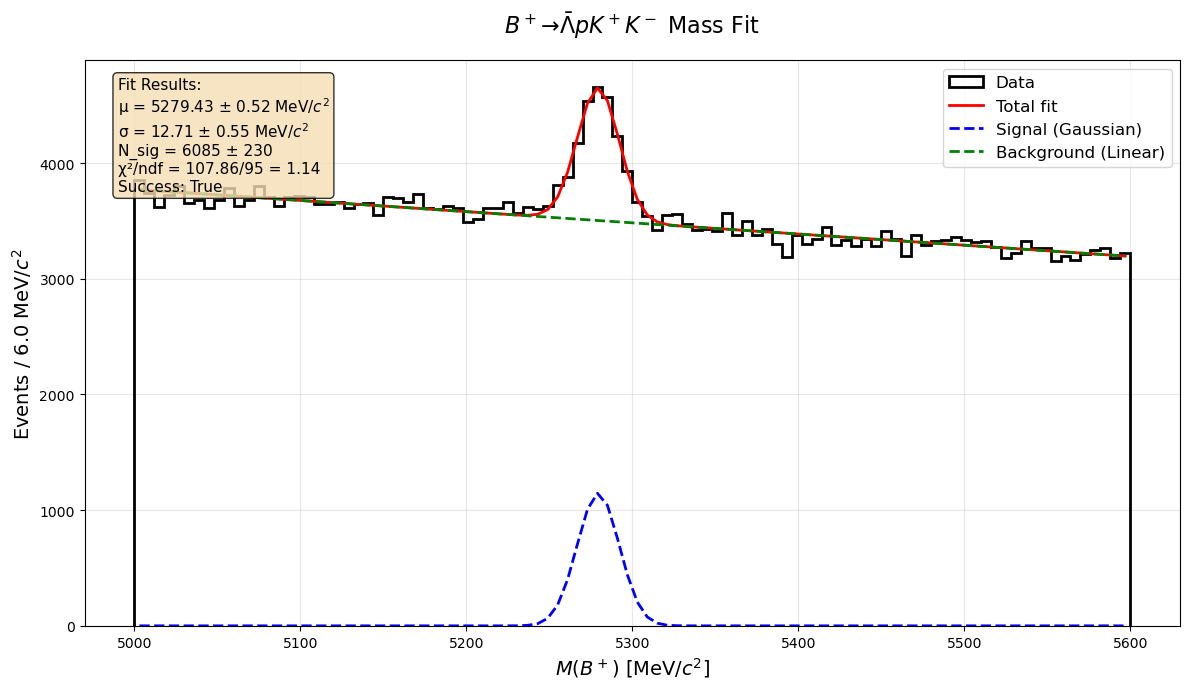

✓ Fit plot complete


In [32]:
# Plot the data with the fit result
fig, ax = plt.subplots(figsize=(12, 7))

# Create histogram of data
counts, bin_edges, _ = ax.hist(data_to_fit, bins=nbins, range=(fit_min, fit_max),
                                histtype='step', linewidth=2, color='black', label='Data')

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

# Evaluate the fit model at bin centers
fit_values = result.predict(bin_centers)

# Plot individual components
signal_values = result.values['n_signal'] * fl.gaussian(mu, sigma)(bin_centers) * bin_width
background_values = result.values['a0'] + result.values['a1'] * bin_centers

# Plot fit and components
ax.plot(bin_centers, fit_values, 'r-', linewidth=2, label='Total fit')
ax.plot(bin_centers, signal_values, 'b--', linewidth=2, label='Signal (Gaussian)')
ax.plot(bin_centers, background_values, 'g--', linewidth=2, label='Background (Linear)')

# Formatting
ax.set_xlabel(r'$M(B^+)$ [MeV/$c^2$]', fontsize=14)
ax.set_ylabel(f'Events / {bin_width:.1f} MeV/$c^2$', fontsize=14)
ax.set_title(r'$B^+ \to \bar{\Lambda} p K^+ K^-$ Mass Fit', fontsize=16, pad=20)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

# Add fit results text box
textstr = f'''Fit Results:
μ = {result.values["mu"]:.2f} ± {result.errors["mu"]:.2f} MeV/$c^2$
σ = {result.values["sigma"]:.2f} ± {result.errors["sigma"]:.2f} MeV/$c^2$
N_sig = {result.values["n_signal"]:.0f} ± {result.errors["n_signal"]:.0f}
χ²/ndf = {result.fval:.2f}/{nbins - len(result.values)} = {result.fval/(nbins - len(result.values)):.2f}
Success: {result.success}'''

ax.text(0.03, 0.97, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("✓ Fit plot complete")

In [64]:
## Apply our selection cuts from the fit results
pass_cuts = (combined_data["Bu_IPCHI2_OWNPV"] < 6) & (combined_data["L0_MM"] > 1111) & (combined_data["L0_MM"] < 1121) & (combined_data["Lp_ProbNNp"] > 0.1)
print(len(pass_cuts))
fail_cuts = np.logical_not(pass_cuts)
print(len(fail_cuts))

1275560
1275560


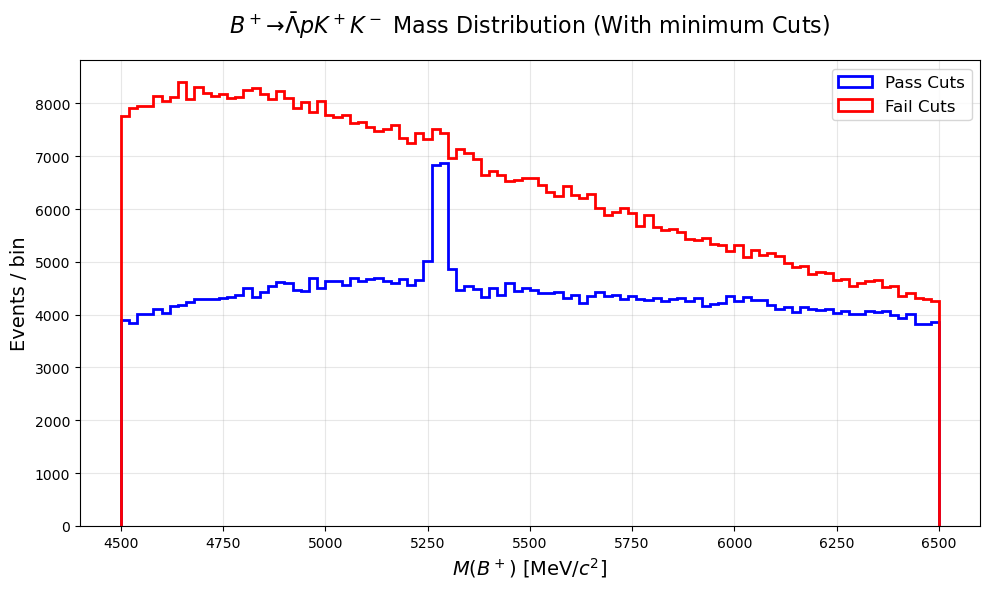

✓ Plot complete


In [65]:
bu_mass_cuts = bu_mass[pass_cuts]
bu_mass_fail_cuts = bu_mass[fail_cuts]

# Plot B+ mass distribution
fig, ax = plt.subplots(figsize=(10, 6))

# Create histogram
n_pass, bins, patches = ax.hist(bu_mass_cuts, bins=100, range=(4500, 6500),
                           histtype='step', linewidth=2, color='blue', label='Pass Cuts')
n_fails, bins, patches = ax.hist(bu_mass_fail_cuts, bins=100, range=(4500, 6500),
                           histtype='step', linewidth=2, color='red', label='Fail Cuts')

# Formatting
ax.set_xlabel(r'$M(B^+)$ [MeV/$c^2$]', fontsize=14)
ax.set_ylabel('Events / bin', fontsize=14)
ax.set_title(r'$B^+ \to \bar{\Lambda} p K^+ K^-$ Mass Distribution (With minimum Cuts)',
             fontsize=16, pad=20)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

print("✓ Plot complete")